In [4]:
!kaggle competitions download -c store-sales-time-series-forecasting

 98%|█████████████████████████████████████▎| 21.0M/21.4M [00:00<00:00, 30.6MB/s]
100%|██████████████████████████████████████| 21.4M/21.4M [00:00<00:00, 29.1MB/s]


In [6]:
!unzip store-sales-time-series-forecasting.zip

Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [1350]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

In [1351]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [1352]:
def create_date_features(df):
    df['month'] = df.date.dt.month.astype("int8")
    df['day_of_month'] = df.date.dt.day.astype("int8")
    df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
    df['week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")
    df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df['year'] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.date.dt.quarter.astype("int8")
    df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
    df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    return df

In [1353]:
train_df = pd.read_csv('train.csv', parse_dates=['date'])
train_df = create_date_features(train_df)
print(f'The shape of the data {train_df.shape}')
train_df.info()

/var/folders/w0/h8xj6tr53wb1vyjdx5qj1ty00000gn/T/ipykernel_86174/4166992176.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")


The shape of the data (3000888, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 22 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                int64         
 1   date              datetime64[ns]
 2   store_nbr         int64         
 3   family            object        
 4   sales             float64       
 5   onpromotion       int64         
 6   month             int8          
 7   day_of_month      int8          
 8   day_of_year       int16         
 9   week_of_month     int8          
 10  week_of_year      int8          
 11  day_of_week       int8          
 12  year              int32         
 13  is_wknd           int8          
 14  quarter           int8          
 15  is_month_start    int8          
 16  is_month_end      int8          
 17  is_quarter_start  int8          
 18  is_quarter_end    int8          
 19  is_year_start     int8          
 20  is_year_en

In [1354]:
train_df.isna().sum(axis = 0)

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
month               0
day_of_month        0
day_of_year         0
week_of_month       0
week_of_year        0
day_of_week         0
year                0
is_wknd             0
quarter             0
is_month_start      0
is_month_end        0
is_quarter_start    0
is_quarter_end      0
is_year_start       0
is_year_end         0
season              0
dtype: int64

In [1355]:
print(f"{len(train_df['store_nbr'].unique())} stores in the dataset")

54 stores in the dataset


In [1356]:
print(f"{len(train_df['family'].unique())} product codes in the dataset")

33 product codes in the dataset


In [1357]:
sales_by_store_and_family = train_df.groupby(by = ['family', 'store_nbr'])['sales'].sum()
stores_family_pairs_always_zero = sales_by_store_and_family[sales_by_store_and_family == 0].index

In [1358]:
print(train_df.shape)
train_df = train_df.reset_index().set_index(['family', 'store_nbr'])
train_df.drop(stores_family_pairs_always_zero, inplace=True)
train_df.reset_index(inplace=True)
print(train_df.shape)

(3000888, 22)
(2911636, 23)


In [1359]:
oil_df = pd.read_csv('oil.csv', parse_dates=[0], index_col=0)
oil_df.asfreq(pd.infer_freq(oil_df.index))
oil_df.bfill(inplace=True)
print(oil_df.info())
print(50 * '-')
print(oil_df.head(3))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1218 entries, 2013-01-01 to 2017-08-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1218 non-null   float64
dtypes: float64(1)
memory usage: 19.0 KB
None
--------------------------------------------------
            dcoilwtico
date                  
2013-01-01       93.14
2013-01-02       93.14
2013-01-03       92.97


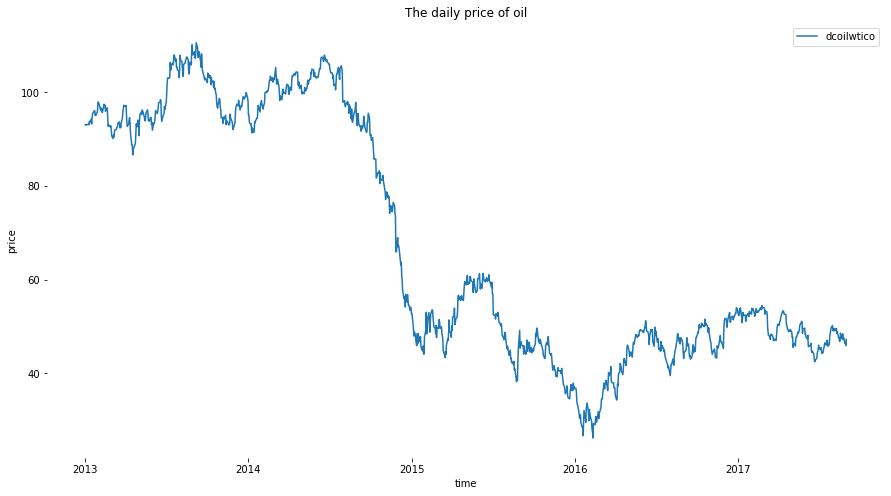

In [1360]:
plt.figure(figsize = (15, 8))
sns.lineplot(data = oil_df).set(title = 'The daily price of oil', ylabel = 'price', xlabel = 'time')
plt.show()

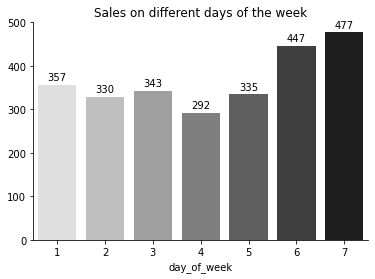

In [1361]:
sales_group_by_day = train_df.groupby(by = 'day_of_week')['sales'].apply(lambda x: np.mean(x))
sns.barplot(x = sales_group_by_day.index, y = sales_group_by_day.values, palette='gray_r')
for index, value in enumerate(sales_group_by_day.values):
    plt.text(index - .2, value + 10, str(round(value)))
plt.gca().set(ylim = (0, 500), title = 'Sales on different days of the week')
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

In [1362]:
train_df

,family,store_nbr,index,id,date,sales,onpromotion,month,day_of_month,day_of_year,...,year,is_wknd,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
0,AUTOMOTIVE,1,0,0,2013-01-01,0.000,0,1,1,1,...,2013,0,1,1,0,1,0,1,0,0
1,BEAUTY,1,2,2,2013-01-01,0.000,0,1,1,1,...,2013,0,1,1,0,1,0,1,0,0
2,BEVERAGES,1,3,3,2013-01-01,0.000,0,1,1,1,...,2013,0,1,1,0,1,0,1,0,0
3,BOOKS,1,4,4,2013-01-01,0.000,0,1,1,1,...,2013,0,1,1,0,1,0,1,0,0
4,BREAD/BAKERY,1,5,5,2013-01-01,0.000,0,1,1,1,...,2013,0,1,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911631,POULTRY,9,3000883,3000883,2017-08-15,438.133,0,8,15,227,...,2017,0,3,0,0,0,0,0,0,2
2911632,PREPARED FOODS,9,3000884,3000884,2017-08-15,154.553,1,8,15,227,...,2017,0,3,0,0,0,0,0,0,2
2911633,PRODUCE,9,3000885,3000885,2017-08-15,2419.729,148,8,15,227,...,2017,0,3,0,0,0,0,0,0,2
2911634,SCHOOL AND OFFICE SUPPLIES,9,3000886,3000886,2017-08-15,121.000,8,8,15,227,...,2017,0,3,0,0,0,0,0,0,2


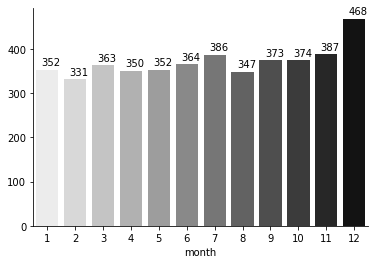

In [1363]:
sales_group_by_month = train_df.groupby(by = 'month')['sales'].apply(lambda x: np.mean(x))
sns.barplot(x = sales_group_by_month.index, y = sales_group_by_month.values, palette='gray_r')
for index, value in enumerate(sales_group_by_month.values):
    plt.text(index - .2, value + 10, str(round(value)))
    
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

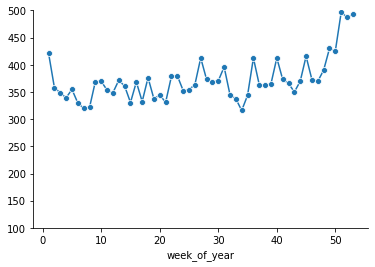

In [1364]:
sales_group_by_week = train_df.groupby(by = 'week_of_year')['sales'].apply(lambda x: np.mean(x))
sns.lineplot(x = sales_group_by_week.index, y = sales_group_by_week.values, marker = 'o')
    
plt.gca().set(ylim = (100, 500))
    
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

In [1365]:
transactions_df = pd.read_csv('transactions.csv', parse_dates=['date'], index_col=['date', 'store_nbr'])
transactions_df.head(3)

transactions
date       store_nbr              
2013-01-01 25                  770
2013-01-02 1                  2111
           2                  2358

In [1366]:
pd.DataFrame(train_df.reset_index().groupby(by = ['date', 'store_nbr'])['sales'].sum()).join(transactions_df, how = 'inner').corr()

,sales,transactions
sales,1.000000,0.837384
transactions,0.837384,1.000000


In [1367]:
pd.DataFrame(train_df.groupby(by = 'date')['sales'].sum()).join(oil_df, on='date').corr()

,sales,dcoilwtico
sales,1.000000,-0.690249
dcoilwtico,-0.690249,1.000000


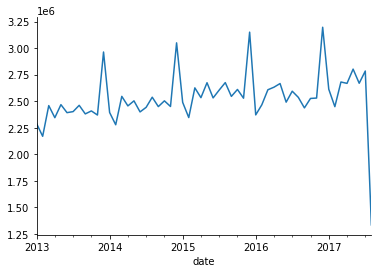

In [1368]:
transactions_df.reset_index().set_index('date').resample('M')['transactions'].sum().plot()
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

---

In [1369]:
stores_df = pd.read_csv('stores.csv')
print(stores_df.info())
print(stores_df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None
   store_nbr   city      state type  cluster
0          1  Quito  Pichincha    D       13
1          2  Quito  Pichincha    D       13
2          3  Quito  Pichincha    D        8


[Text(0.5, 1.0, 'sum of sales in each cluster'), Text(0, 0.5, 'Sales')]

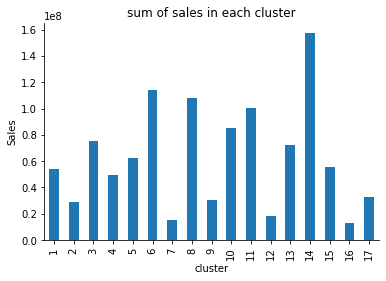

In [1370]:
pd.merge(left = train_df, left_on='store_nbr', right = stores_df, right_on='store_nbr', how = 'inner').groupby('cluster')['sales'].sum().plot(kind = 'bar')
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().set(title = 'sum of sales in each cluster', ylabel = 'Sales')

[Text(0.5, 1.0, 'sum of sales in each store type'), Text(0, 0.5, 'Sales')]

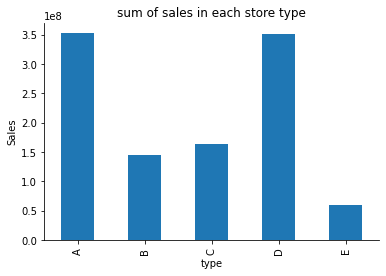

In [1371]:
pd.merge(left = train_df, left_on='store_nbr', right = stores_df, right_on='store_nbr', how = 'inner').groupby('type')['sales'].sum().plot(kind = 'bar')
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().set(title = 'sum of sales in each store type', ylabel = 'Sales')

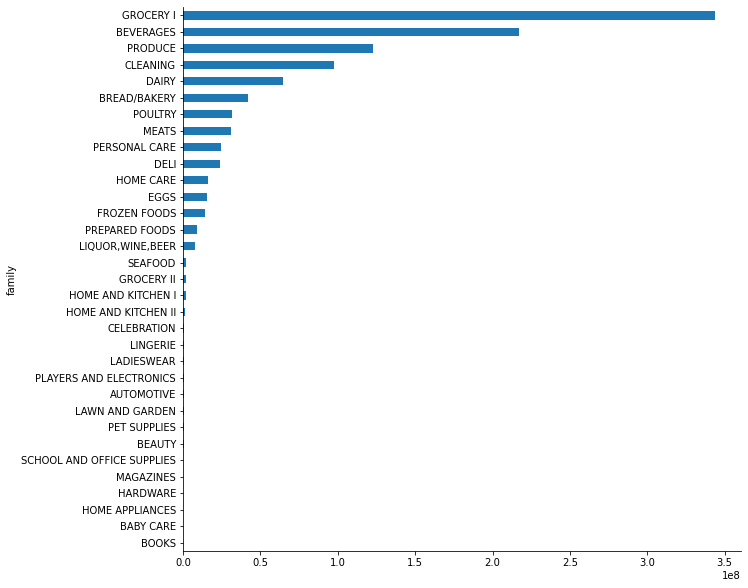

In [1372]:
plt.figure(figsize = (10, 10))
train_df.groupby('family')['sales'].sum().sort_values(ascending=True).plot(kind = 'barh')
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

In [1373]:
train_df = pd.merge(left = train_df, left_on='store_nbr', right = stores_df, right_on='store_nbr')

In [1374]:
holidays_df = pd.read_csv('holidays_events.csv')
holidays_df.date = pd.to_datetime(holidays_df.date)
print(holidays_df.info())
holidays_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB
None


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


In [1375]:
holidays = holidays_df[(holidays_df['type'] != 'Transfer') & (holidays_df['transferred'] == False)].drop('transferred', axis = 1)
transferred_holidays = holidays_df[holidays_df['type'] == 'Transfer'].drop('transferred', axis = 1)
holidays_df = pd.concat([transferred_holidays, holidays])

In [1376]:
holidays_df.description = holidays_df.description.str.replace('-', '').str.replace('+', '').str.replace(r'\d+', '')
holidays_df.description = holidays_df.description.str.replace('recupero puente', '')
holidays_df.description = holidays_df.description.str.replace('puente', '')
holidays_df.description = holidays_df.description.str.lower()

holidays_df.type = holidays_df.type.replace('Additional', 'Holiday')
holidays_df.type = holidays_df.type.replace('Bridge', 'Holiday')
holidays_df.type = holidays_df.type.replace('Transfer', 'Holiday')

holidays_df = holidays_df[holidays_df.type != 'Work Day']

holidays_df.drop('type', inplace = True, axis = 1)

holidays_df.description = np.where(holidays_df.description.str.contains('futbol'), 'futbol', holidays_df.description)
holidays_df.description = holidays_df.description.str.replace(' ', '_')

/var/folders/w0/h8xj6tr53wb1vyjdx5qj1ty00000gn/T/ipykernel_86174/139930540.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  holidays_df.description = holidays_df.description.str.replace('-', '').str.replace('+', '').str.replace(r'\d+', '')
/var/folders/w0/h8xj6tr53wb1vyjdx5qj1ty00000gn/T/ipykernel_86174/139930540.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  holidays_df.description = holidays_df.description.str.replace('-', '').str.replace('+', '').str.replace(r'\d+', '')


In [1377]:
national_holidays = holidays_df[holidays_df.locale == 'National'].drop('locale', axis = 1)
regional_holidays = holidays_df[holidays_df.locale == 'Regional'].drop('locale', axis = 1)
local_holidays = holidays_df[holidays_df.locale == 'Local'].drop('locale', axis = 1)

In [1378]:
national_holidays[national_holidays.date.duplicated(keep=False)]

,date,locale_name,description
35,2012-12-24,Ecuador,puente_navidad
36,2012-12-24,Ecuador,navidad
39,2012-12-31,Ecuador,puente_primer_dia_del_ano
40,2012-12-31,Ecuador,primer_dia_del_ano
156,2014-12-26,Ecuador,puente_navidad
157,2014-12-26,Ecuador,navidad
235,2016-05-01,Ecuador,dia_del_trabajo
236,2016-05-01,Ecuador,terremoto_manabi
242,2016-05-07,Ecuador,dia_de_la_madre
243,2016-05-07,Ecuador,terremoto_manabi


In [1379]:
national_holidays, regional_holidays, local_holidays = list(map(
    lambda x: pd.get_dummies(x, columns= ['description'], prefix = 'Holiday')
, [national_holidays, regional_holidays, local_holidays]))

In [1380]:
national_holidays = national_holidays.groupby(by = 'date').sum().reset_index()
regional_holidays = regional_holidays.groupby(by = ['locale_name', 'date']).sum().reset_index().rename(columns={'locale_name': 'state'})
local_holidays = local_holidays.groupby(by = ['locale_name', 'date']).sum().reset_index().rename(columns={'locale_name': 'city'})

In [1381]:
local_holidays.drop('Holiday_traslado_fundacion_de_quito', axis = 1, inplace = True)

In [1382]:
train_df.shape

(2911636, 27)

In [1383]:
train_df = pd.merge(left = train_df, left_on=['date'], right = national_holidays, right_on='date', how = 'left')
train_df = pd.merge(left = train_df, left_on=['date', 'city'], right = local_holidays, right_on=['date', 'city'], how = 'left')
train_df = pd.merge(left = train_df, left_on=['date', 'state'], right = regional_holidays, right_on=['date', 'state'], how = 'left')

In [1384]:
train_df[train_df.columns[train_df.columns.str.startswith('Holiday')]] = train_df[train_df.columns[train_df.columns.str.startswith('Holiday')]].fillna(0)

In [1385]:
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == 1][target]
    groupB = dataframe[dataframe[group] == 0][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    temp["Feature"] = group
    temp["GroupA_mean"] = groupA.mean()
    temp["GroupB_mean"] = groupB.mean()
    temp["GroupA_median"] = groupA.median()
    temp["GroupB_median"] = groupB.median()
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Feature","Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    else:
        temp = temp[["Feature","Test Type","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    
    return temp

In [1386]:
train_df.shape

(2911636, 77)

In [1387]:
AB_testing_results_df = pd.DataFrame()
columns = train_df.columns[train_df.columns.str.startswith('Holiday')]
for column in columns:
    AB_testing_results_df = AB_testing_results_df.append(AB_Test(train_df, column, 'sales'))
train_df = train_df.drop(columns = AB_testing_results_df[AB_testing_results_df['AB Hypothesis'] == 'Fail to Reject H0'].Feature, axis = 1)

/Users/user/miniforge3/envs/general/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [1388]:
train_df.set_index('date', inplace=True)
train_df.sort_index(inplace=True)

In [1389]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [1390]:
main_df = train_df.copy()

---

In [1511]:
train_df = main_df.copy()

In [1512]:
import re
train_df.reset_index(inplace=True)
train_df = pd.get_dummies(train_df, columns=['city', 'state', 'type'])
train_df = train_df.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
train_df.drop(columns=['index', 'id', 'date'], axis=1, inplace = True)

In [1513]:
y = train_df.pop('sales')
X = train_df

In [1514]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

In [1517]:
from tqdm.auto import tqdm
models = dict()
for family, store in tqdm(zip(train_df.family.unique(), train_df.store_nbr.unique()), leave=False):
    train_indices = X_train[(X_train['family'] == family) & (X_train.store_nbr == store)].index
    X_train_filtered = X_train.loc[train_indices].drop(columns=['family', 'store_nbr'], axis = 1)
    y_train_filtered = y_train.loc[train_indices]

    test_indices = X_test[(X_test['family'] == family) & (X_test.store_nbr == store)].index
    X_test_filtered = X_test.loc[test_indices].drop(columns=['family', 'store_nbr'], axis = 1)
    y_test_filtered = y_test.loc[test_indices]


    model = lgb.LGBMRegressor(learning_rate=0.005, max_depth = -20, random_state=42)
    model.fit(X_train_filtered, y_train_filtered, eval_set=[(X_test_filtered, y_test_filtered), (X_train_filtered, y_train_filtered)], verbose=False)
    
    models[(family, store)] = model

0it [00:00, ?it/s]

In [1479]:
# print('Training accuracy {:.4f}'.format(model.score(X_train, y_train)))
# print('Testing accuracy {:.4f}'.format(model.score(X_test, y_test)))

In [1478]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 30))
# lgb.plot_importance(model, ax = ax)

In [1477]:
# lgb.plot_metric(model)